In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer, AerSimulator

In [2]:
def nXOR(qc, qubits, output):
    for q in qubits:
        qc.cx(q, output)
    qc.barrier()

def XOR1(qc, a, output):
    qc.cx(a, output)
    qc.barrier()

def get_phase_gate(n):
    size = 2**n
    i = -np.eye(size)
    i[0][0] = 1
    phase_gate = UnitaryGate(i)
    return phase_gate

In [3]:
def diffuser(n):
    qc = QuantumCircuit(n)
    for q in range(n):
        qc.h(q)
    qc.append(get_phase_gate(n), range(n))
    for q in range(n):
        qc.h(q)
    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s

In [4]:
def generate_clause_list(A, n):
    clause_list = []
    
    for i in range(n):
        l = []
        for j in range(n):
            if A.item((i, j)) == 1:
                l.append(j)
        clause_list.append(l)
    
    return clause_list

In [5]:
def lights_out_oracle(n, qc, var_qubits, p_qubits, eq_qubits, sol_qubit, c_bits, clause_list):
    
    qc.barrier()
    i = 0
    for clause in clause_list:
        clause = [var_qubits[c] for c in clause]
        nXOR(qc, clause, eq_qubits[i])
        i += 1
    
    for i in range(n):
        XOR1(qc, p_qubits[i], eq_qubits[i])
    qc.x(eq_qubits)
    
    qc.mcx(eq_qubits, sol_qubit)
    
    i = 0
    for clause in clause_list:
        clause = [var_qubits[c] for c in clause]
        nXOR(qc, clause, eq_qubits[i])
        i += 1
    
    for i in range(n):
        XOR1(qc, p_qubits[i], eq_qubits[i])
    qc.x(eq_qubits)
    
    qc.barrier()
    
    qc.append(diffuser(n), range(n))
    

In [6]:
def lights_out_solver(A, p, n, t):
    var_qubits = QuantumRegister(n, name='click')
    p_qubits = QuantumRegister(n, name='initial')
    eq_qubits = QuantumRegister(n, name='output')  
    sol_qubit = QuantumRegister(1, name='solution')
    c_bits = ClassicalRegister(n, name='classical')
    
    clause_list = generate_clause_list(A, n)
    qc = QuantumCircuit(var_qubits, p_qubits, eq_qubits, sol_qubit, c_bits)
    
    # INITIALIZATION
    # - STATE on SOLUTION QUBIT
    qc.x(sol_qubit)
    qc.h(sol_qubit)
    
    # Initial state to solve
    for i in range(n):
        if p[i] == 1:
            qc.x(p_qubits[i])
    
    
    # SUPERPOSITION OF BITSTRING
    qc.h(var_qubits)
    
    for i in range(t):
        lights_out_oracle(n, qc, var_qubits, p_qubits, eq_qubits, sol_qubit, c_bits, clause_list)
    
    for i in range(n):
        qc.measure(var_qubits[i], c_bits[i])
    
    return qc

In [7]:
A = np.matrix([[1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 1, 1, 1],
 [1, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 0, 0, 1, 1],
 [0, 0, 1, 0, 1, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 1],
 [0, 1, 0, 1, 0, 0, 1, 1]])
print(A)

[[1 1 1 0 0 0 0 0]
 [1 1 1 1 0 1 1 1]
 [1 1 1 0 1 1 0 0]
 [0 1 0 1 0 0 1 1]
 [0 0 1 0 1 1 1 0]
 [0 1 1 0 1 1 0 0]
 [0 1 0 1 1 0 1 1]
 [0 1 0 1 0 0 1 1]]


In [18]:
G = nx.Graph(A - np.eye(A.shape[0]))

In [21]:
print("RANK : ", np.linalg.matrix_rank(A))

RANK :  7


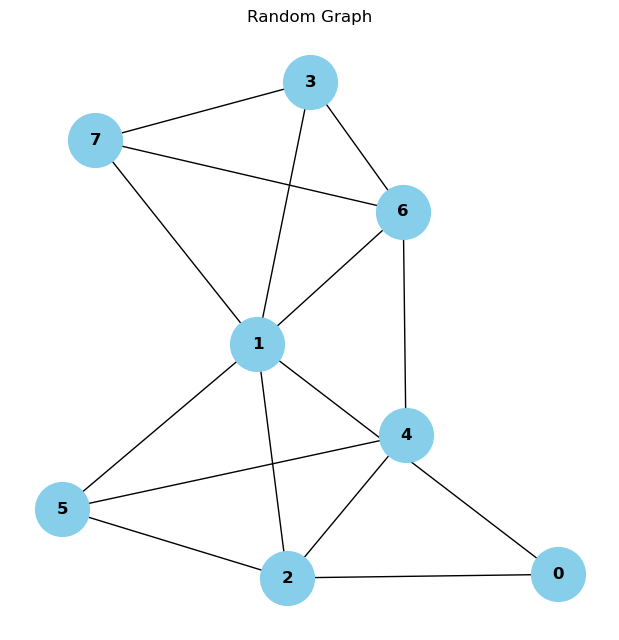

In [19]:
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, font_size=12, font_weight='bold')
plt.title("Random Graph")
plt.show()

In [10]:
p = np.random.randint(2, size=len(A))
qc = lights_out_solver(A, p, len(A), 3)

In [17]:
qc.draw(filename=f"dim_{A.shape[0]}_{A.shape[1]}.jpeg")

┌───┐      ░                 ░                                    »
    click_0: ┤ H ├──────░───■─────────────░───■────────────────────────────────»
             ├───┤      ░   │             ░   │                                »
    click_1: ┤ H ├──────░───┼────■────────░───┼────■───────────────────────────»
             ├───┤      ░   │    │        ░   │    │                           »
    click_2: ┤ H ├──────░───┼────┼────■───░───┼────┼────■──────────────────────»
             ├───┤      ░   │    │    │   ░   │    │    │                      »
    click_3: ┤ H ├──────░───┼────┼────┼───░───┼────┼────┼────■─────────────────»
             ├───┤      ░   │    │    │   ░   │    │    │    │                 »
    click_4: ┤ H ├──────░───┼────┼────┼───░───┼────┼────┼────┼─────────────────»
             ├───┤      ░   │    │    │   ░   │    │    │    │                 »
    click_5: ┤ H ├──────░───┼────┼────┼───░───┼────┼────┼────┼────■────────────»
             ├───┤      ░   │    │    │   ░   │    │    │    │    │            »
    click_6: ┤ H ├──────░───┼────┼────┼───░───┼────┼────┼────┼────┼────■───────»
             ├───┤      ░   │    │    │   ░   │    │    │    │    │    │       »
    click_7: ┤ H ├──────░───┼────┼────┼───░───┼────┼────┼────┼────┼────┼────■──»
             ├───┤      ░   │    │    │   ░   │    │    │    │    │    │    │  »
  initial_0: ┤ X ├──────░───┼────┼────┼───░───┼────┼────┼────┼────┼────┼────┼──»
             └───┘      ░   │    │    │   ░   │    │    │    │    │    │    │  »
  initial_1: ───────────░───┼────┼────┼───░───┼────┼────┼────┼────┼────┼────┼──»
             ┌───┐      ░   │    │    │   ░   │    │    │    │    │    │    │  »
  initial_2: ┤ X ├──────░───┼────┼────┼───░───┼────┼────┼────┼────┼────┼────┼──»
             └───┘      ░   │    │    │   ░   │    │    │    │    │    │    │  »
  initial_3: ───────────░───┼────┼────┼───░───┼────┼────┼────┼────┼────┼────┼──»
             ┌───┐      ░   │    │    │   ░   │    │    │    │    │    │    │  »
  initial_4: ┤ X ├──────░───┼────┼────┼───░───┼────┼────┼────┼────┼────┼────┼──»
             ├───┤      ░   │    │    │   ░   │    │    │    │    │    │    │  »
  initial_5: ┤ X ├──────░───┼────┼────┼───░───┼────┼────┼────┼────┼────┼────┼──»
             ├───┤      ░   │    │    │   ░   │    │    │    │    │    │    │  »
  initial_6: ┤ X ├──────░───┼────┼────┼───░───┼────┼────┼────┼────┼────┼────┼──»
             └───┘      ░   │    │    │   ░   │    │    │    │    │    │    │  »
  initial_7: ───────────░───┼────┼────┼───░───┼────┼────┼────┼────┼────┼────┼──»
                        ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░   │    │    │    │    │    │    │  »
   output_0: ───────────░─┤ X ├┤ X ├┤ X ├─░───┼────┼────┼────┼────┼────┼────┼──»
                        ░ └───┘└───┘└───┘ ░ ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐»
   output_1: ───────────░─────────────────░─┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
                        ░                 ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘»
   output_2: ───────────░─────────────────░────────────────────────────────────»
                        ░                 ░                                    »
   output_3: ───────────░─────────────────░────────────────────────────────────»
                        ░                 ░                                    »
   output_4: ───────────░─────────────────░────────────────────────────────────»
                        ░                 ░                                    »
   output_5: ───────────░─────────────────░────────────────────────────────────»
                        ░                 ░                                    »
   output_6: ───────────░─────────────────░────────────────────────────────────»
                        ░                 ░                                    »
   output_7: ───────────░─────────────────░────────────────────────────────────»
             ┌───┐┌───┐ ░                 ░                                    »
   solution: ┤ X ├┤ H ├─░─────────────────░─

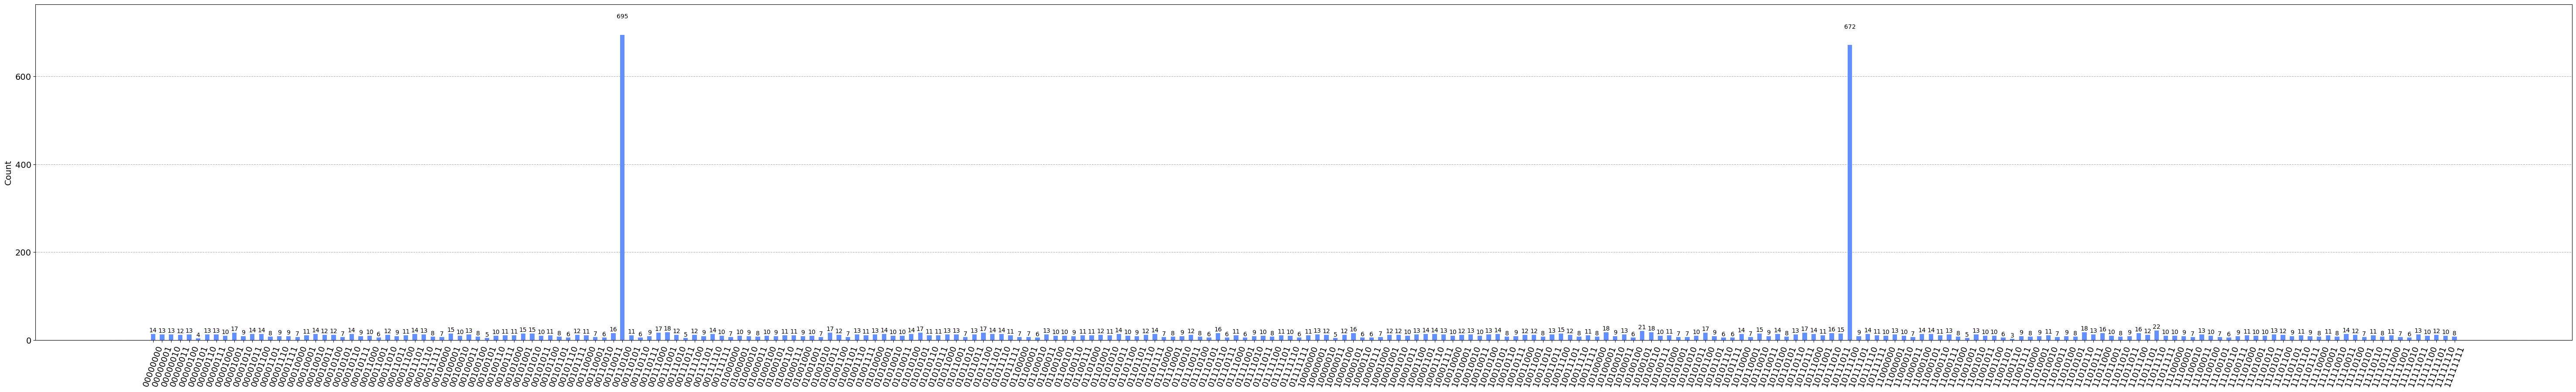

In [16]:
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_simulator.run(transpiled_qc, shots=4096).result()
plot_histogram(result.get_counts(), figsize=(75, 10))

In [20]:
result.get_counts()

{'11001101': 6,
 '10110001': 7,
 '01111111': 6,
 '00011100': 11,
 '01100001': 7,
 '00001010': 9,
 '11101100': 12,
 '10101111': 6,
 '00100110': 10,
 '11101101': 9,
 '01000100': 10,
 '11101001': 10,
 '00111101': 9,
 '10100110': 18,
 '11100111': 9,
 '10101001': 7,
 '10010001': 12,
 '01000111': 11,
 '11000011': 7,
 '11010101': 8,
 '00011111': 8,
 '01111001': 6,
 '00100010': 10,
 '01000101': 9,
 '00101110': 6,
 '11110000': 8,
 '01100010': 6,
 '10111010': 16,
 '00101010': 15,
 '00110001': 7,
 '11010010': 11,
 '00001101': 8,
 '01010011': 10,
 '11000101': 14,
 '01011100': 17,
 '01010001': 14,
 '10101010': 7,
 '01110100': 8,
 '00000010': 13,
 '01010101': 17,
 '10110000': 14,
 '10101101': 9,
 '00110101': 11,
 '00011001': 6,
 '00001000': 10,
 '01101101': 9,
 '11111011': 13,
 '00111110': 14,
 '01100111': 11,
 '11001000': 8,
 '01001100': 12,
 '00010000': 7,
 '11110100': 12,
 '01101000': 11,
 '11010110': 18,
 '01011111': 11,
 '01010111': 11,
 '10110111': 17,
 '11001011': 10,
 '00100100': 8,
 '000001